<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Cracking_captcha_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries and pip packages

In [1]:
!pip install captcha

     |████████████████████████████████| 102kB 5.6MB/s 


In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

import os
import glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string

import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, adam, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras.utils import np_utils

from keras.utils import Sequence

Using TensorFlow backend.


## Step 1: Captcha generator

#### Two methods:

- generate a large number of Captcha, and save them all at once
- generate a batch of Captcha, and feed the batch of Captcha in the model once, and generate again (very slow, but infinite number of Captcha are available) **This method is used for this study**

### 1. All characters 

n_classes = 36

In [3]:
characters = string.digits + string.ascii_uppercase
characters

'0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

### 2. One example of the captcha

- 170 * 40 images
- 4 characters randomly choosen from the characters determined above

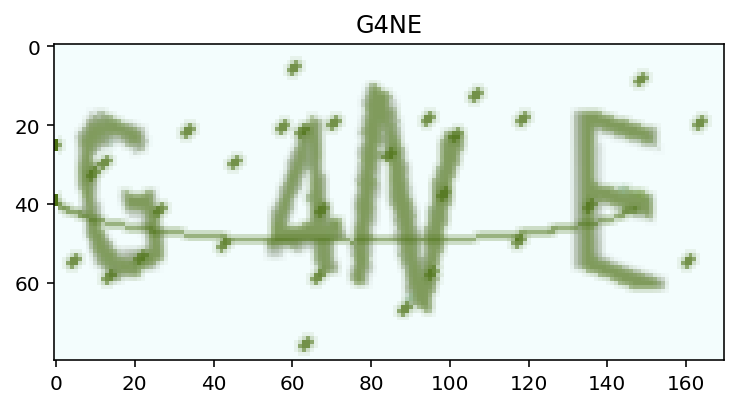

In [4]:
width, height, n_len, n_class = 170, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)
plt.show()

### 3. Generate 10,000 Captchas, and save them to the Google Drive

- the input: the images
- the label: the filename of the images

#### 3.1 Import drive

In [9]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


#### 3.2 Generate data and save them in google drive (only generate once)

In [0]:
"""
os.mkdir('/content/drive/My Drive/Deep Learning projects/Captcha/')

width, height, n_len, n_class = 170, 80, 4, len(characters)
for i in range(10001):
  generator = ImageCaptcha(width=width, height=height)
  random_str = ''.join([random.choice(characters) for j in range(4)])
  img = generator.generate_image(random_str)
  plt.savefig("/content/drive/My Drive/Deep Learning projects/Captcha/"+ str(i) + "_"+random_str + ".png")
"""

## Step 2: Data Generator

Use image fit_generator to train the model:
 - only need to generator a batch a data each time, do not need to store a large number of images which cost memory
 - can yield infinite data
 
The **input (X)**: X.shape = (batch_size, height, width, 3)
- e.g. X.shape = (128, 170, 80, 3) indicate that the batch_size = 128, the image is a 170 * 80 * 3 image

The **output (Y)**: Y.shape = (batch_size, n_class), for each image, the output is 1 * 36 matrix.
- The Y.shape = 4 * [128, 36] since the length is 4


### 1. Define the generator

In [0]:
class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

In [0]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

### 2. Data preparation

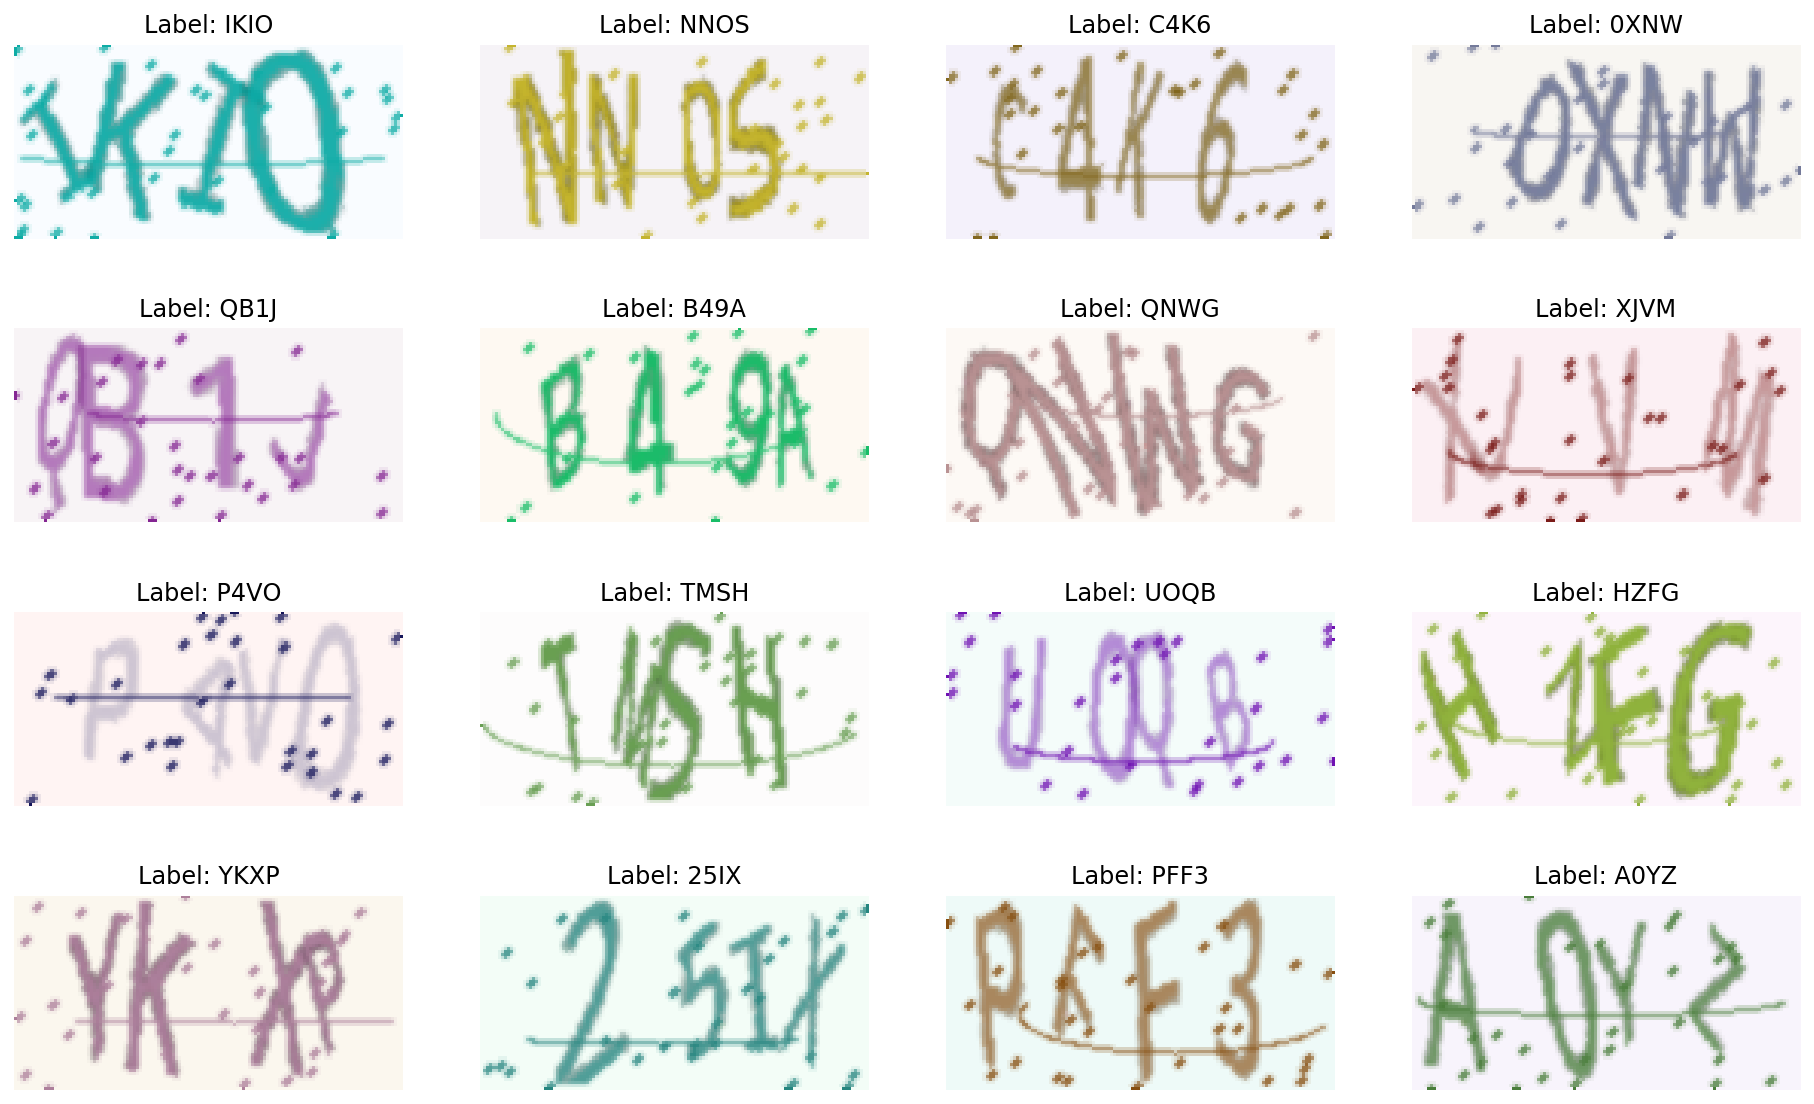

In [89]:
data = CaptchaSequence(characters, batch_size=1, steps=1)
fig = plt.figure(figsize = (16, 10))
for i in range(16):
  ax = fig.add_subplot(4, 4, 1 + i, xticks = [], yticks = [])
  X, y = data[0]
  plt.imshow(X[0])
  plt.axis('off')
  plt.title("Label: {}".format(decode(y)))
plt.show()

## Step 3: CNN Model building

In [14]:
from keras.layers import Input
from keras.models import Model

height = 64
width = 128


input_tensor = Input((height, width, 3))
o = input_tensor

# 4 layers
o = Conv2D(32, kernel_size = 3, padding='same', kernel_initializer='he_uniform') (o)
o = BatchNormalization() (o)
o = Activation("relu") (o)

o = Conv2D(32, kernel_size = 3, padding='same', kernel_initializer='he_uniform') (o)
o = BatchNormalization() (o)
o = Activation("relu") (o)

o = Conv2D(32, kernel_size = 3, padding='same', kernel_initializer='he_uniform') (o)
o = BatchNormalization() (o)
o = Activation("relu") (o)

o = Conv2D(32, kernel_size = 3, padding='same', kernel_initializer='he_uniform') (o)
o = BatchNormalization() (o)
o = Activation("relu") (o)

o = MaxPooling2D(2) (o)

o = Flatten() (o)
o = [Dense(n_class, activation = "softmax", name='c%d'%(i+1))(o) for i in range(n_len)]
model = Model(inputs = input_tensor, outputs = o)
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()









Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 128, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 128, 32)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________

### Model visualization

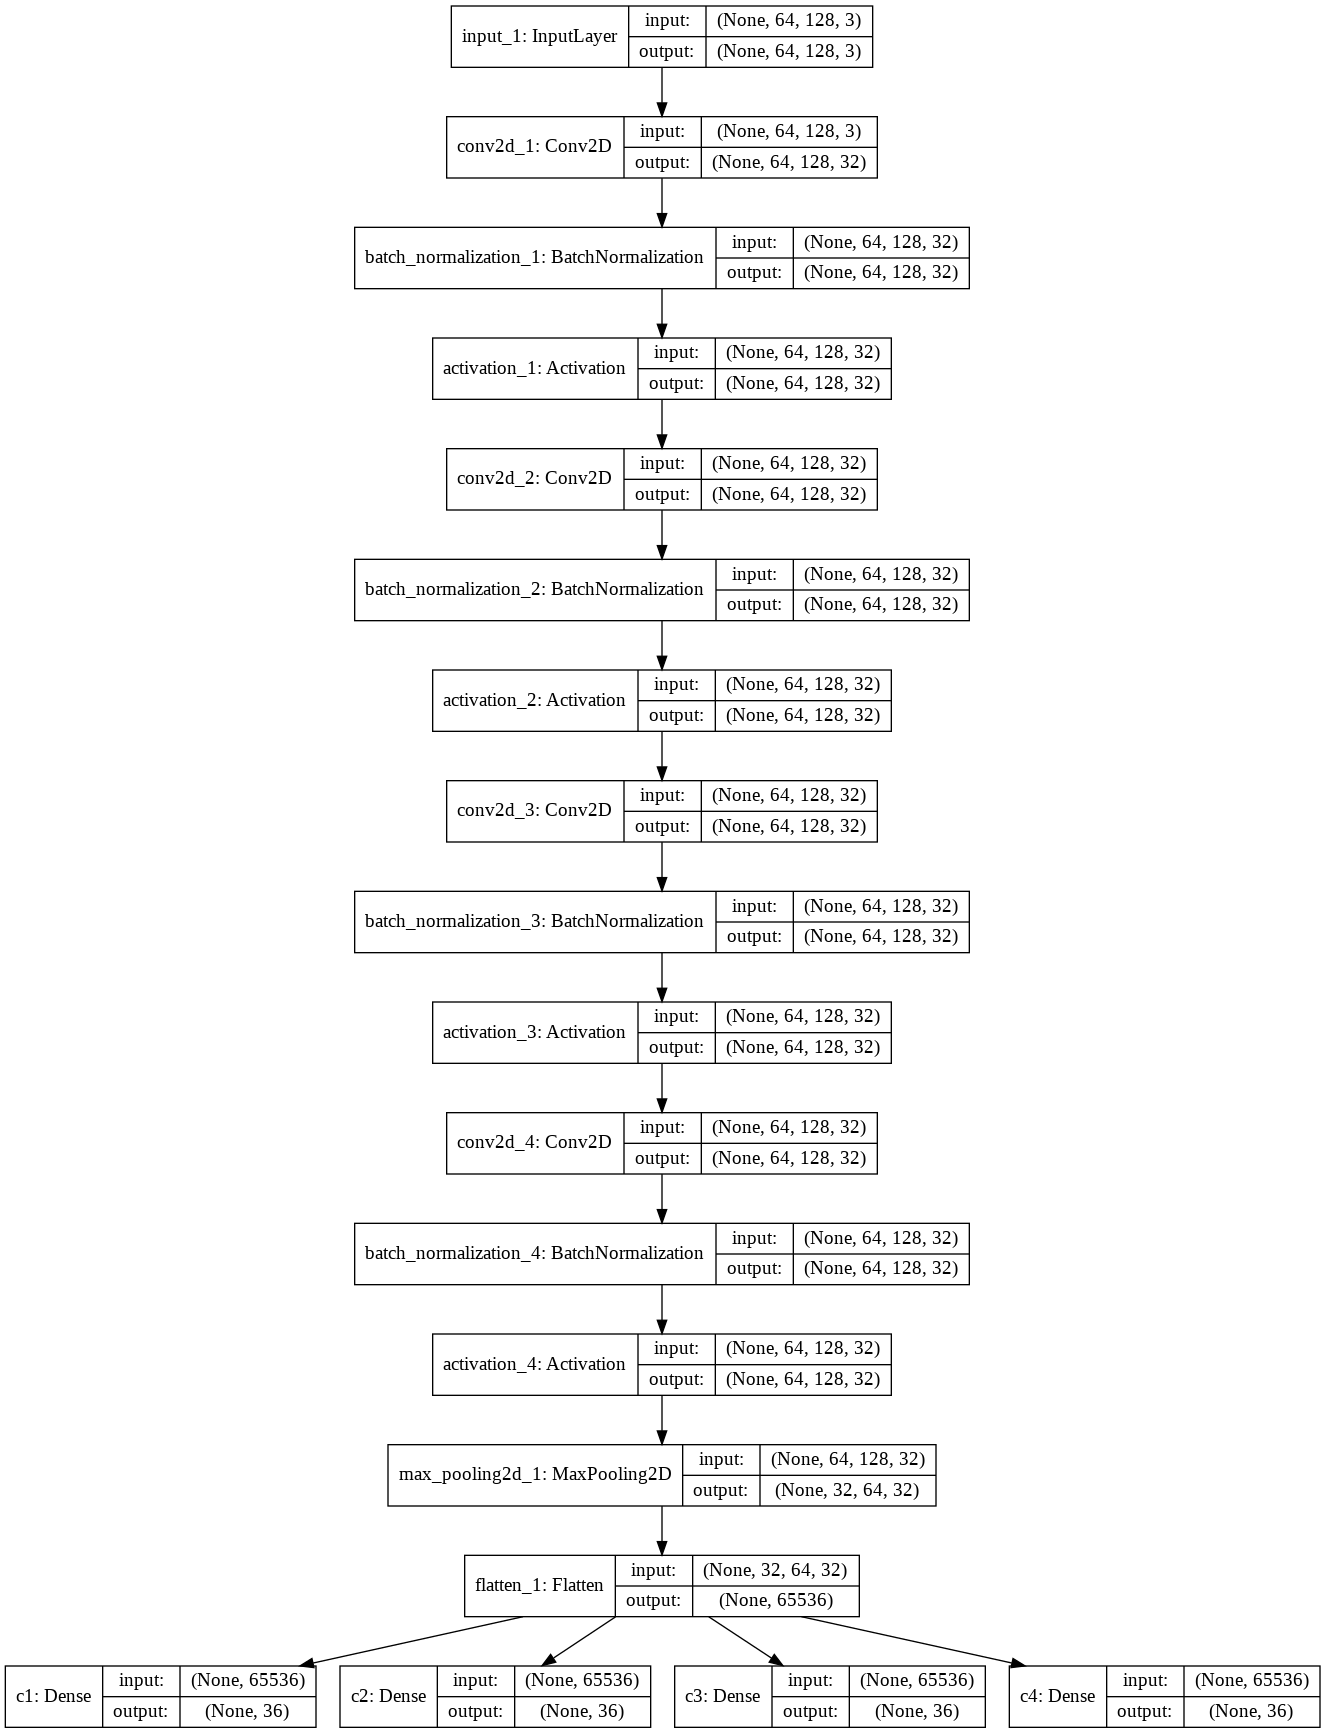

In [15]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file = "cnn.png", show_shapes = True)
Image("cnn.png")

## Step 5: Model Training

In [16]:
train_data = CaptchaSequence(characters, batch_size = 100, steps = 1000)
valid_data = CaptchaSequence(characters, batch_size = 100, steps = 100)
callback_lists = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]


history = model.fit_generator(train_data, epochs=100, 
                    validation_data= valid_data, 
                    workers=4, 
                    use_multiprocessing=True,  # works = 4 让Keras 自动实现多进程生成数据
                    #steps_per_epoch = 100, 
                    callbacks=callback_lists)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
1000/1000 [==============================] - 373s 373ms/step - loss: 41.1983 - c1_loss: 10.4934 - c2_loss: 10.3770 - c3_loss: 10.3134 - c4_loss: 10.0145 - c1_acc: 0.1036 - c2_acc: 0.0861 - c3_acc: 0.0949 - c4_acc: 0.1278 - val_loss: 9.3746 - val_c1_loss: 2.0911 - val_c2_loss: 2.6283 - val_c3_loss: 2.4927 - val_c4_loss: 2.1626 - val_c1_acc: 0.4566 - val_c2_acc: 0.2977 - val_c3_acc: 0.3296 - val_c4_acc: 0.4302
Epoch 2/100
1000/1000 [==============================] - 364s 364ms/step - loss: 4.2789 - c1_loss: 0.6839 - c2_loss: 1.5459 - c3_loss: 1.3369 - c4_loss: 0.7121 - c1_acc: 0.7945 - c2_acc: 0.5765 - c3_acc: 0.6286 - c4_acc: 0.7882 - val_loss: 3.3949 - val_c1_loss: 0.4564 - val_c2_loss: 1.3295 - val_c3_loss: 1.1139 - val_c4_loss: 0.4951 - val_c1_acc: 0.8641 - val_c2_acc: 0.6418 - val_c3_acc: 0.6953 - val_c4_acc: 0.8540
Epoch 3/100
1000/1000 [==============================] - 367s 3

In [0]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer="adam", 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=2, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

## Step 6: Model Evaluation
- Loss & accuracy analysis

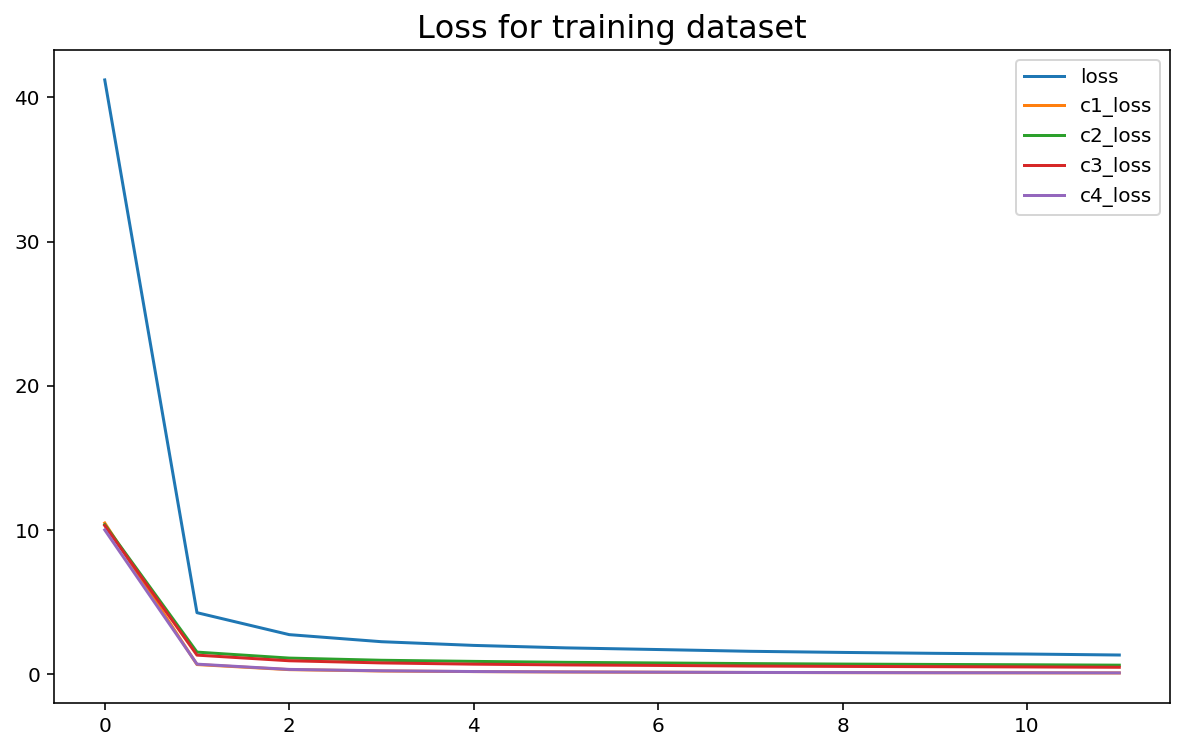

In [45]:
plt.figure(figsize = (10, 6))
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["c1_loss"], label = "c1_loss")
plt.plot(history.history["c2_loss"], label = "c2_loss")
plt.plot(history.history["c3_loss"], label = "c3_loss")
plt.plot(history.history["c4_loss"], label = "c4_loss")
plt.title("Loss for training dataset", size = 16)
plt.legend()
plt.show()

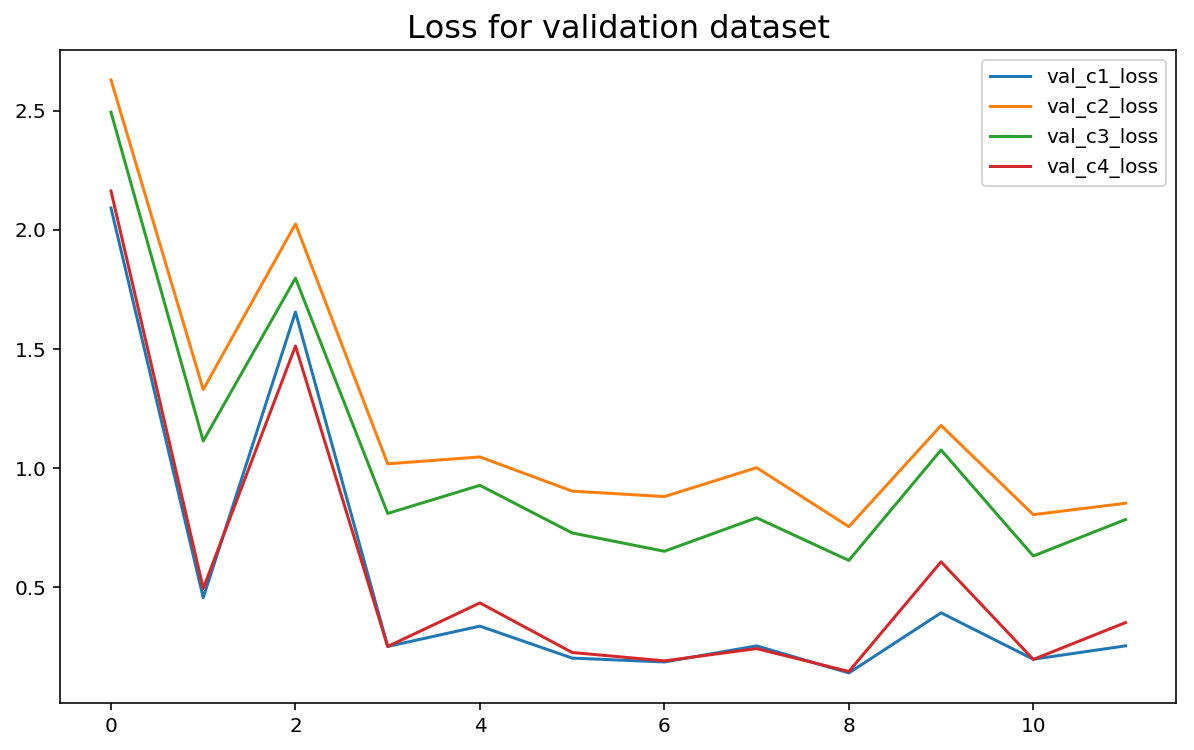

In [46]:
plt.figure(figsize = (10, 6))
plt.plot(history.history["val_c1_loss"], label = "val_c1_loss")
plt.plot(history.history["val_c2_loss"], label = "val_c2_loss")
plt.plot(history.history["val_c3_loss"], label = "val_c3_loss")
plt.plot(history.history["val_c4_loss"], label = "val_c4_loss")
plt.title("Loss for validation dataset", size = 16)
plt.legend()
plt.show()

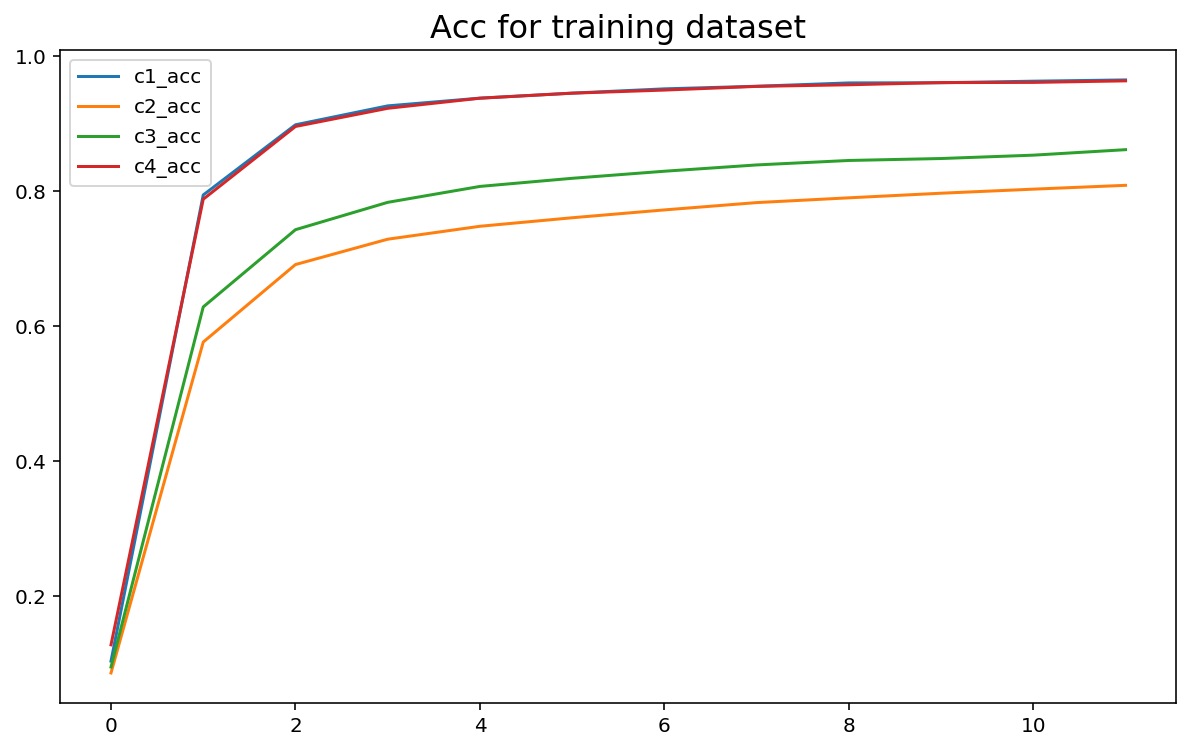

In [83]:
plt.figure(figsize = (10, 6))
plt.plot(history.history["c1_acc"], label = "c1_acc")
plt.plot(history.history["c2_acc"], label = "c2_acc")
plt.plot(history.history["c3_acc"], label = "c3_acc")
plt.plot(history.history["c4_acc"], label = "c4_acc")
plt.title("Acc for training dataset", size = 16)
plt.legend()
plt.show()

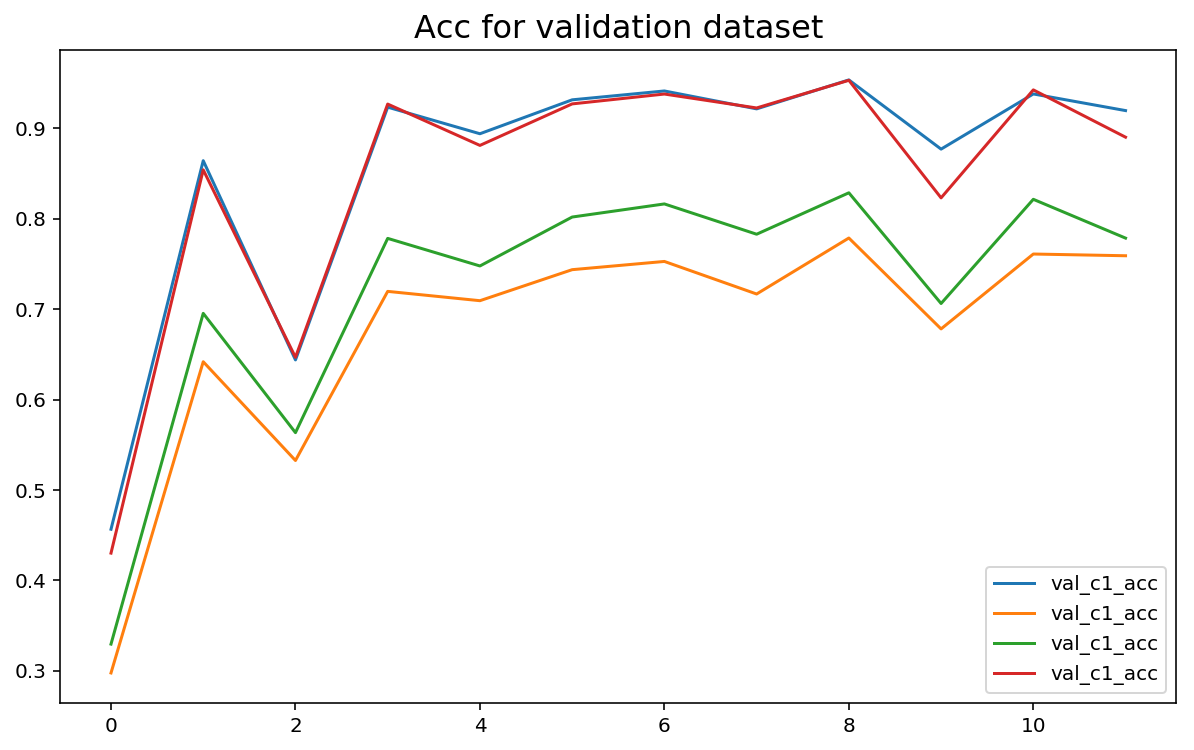

In [51]:
plt.figure(figsize = (10, 6))
plt.plot(history.history["val_c1_acc"], label = "val_c1_acc")
plt.plot(history.history["val_c2_acc"], label = "val_c1_acc")
plt.plot(history.history["val_c3_acc"], label = "val_c1_acc")
plt.plot(history.history["val_c4_acc"], label = "val_c1_acc")
plt.title("Acc for validation dataset", size = 16)
plt.legend()
plt.show()

## Step 7: The model performance evaluation as a whole

In [29]:
from tqdm import tqdm
def evaluate(model, batch_num = 100):
  batch_acc = 0
  with tqdm(CaptchaSequence(characters, batch_size = 128, steps = 100)) as pbar:
    for X, y in pbar:
      y_pred = model.predict(X)
      y_pred = np.argmax(y_pred, axis = -1).T
      y_true = np.argmax(y, axis = -1).T
      
      batch_acc += (y_true == y_pred).all(axis = -1).mean()
  return batch_acc/batch_num

evaluate(model)

100%|██████████| 100/100 [00:52<00:00,  1.93it/s]


0.500625

## Step 8: Prediction

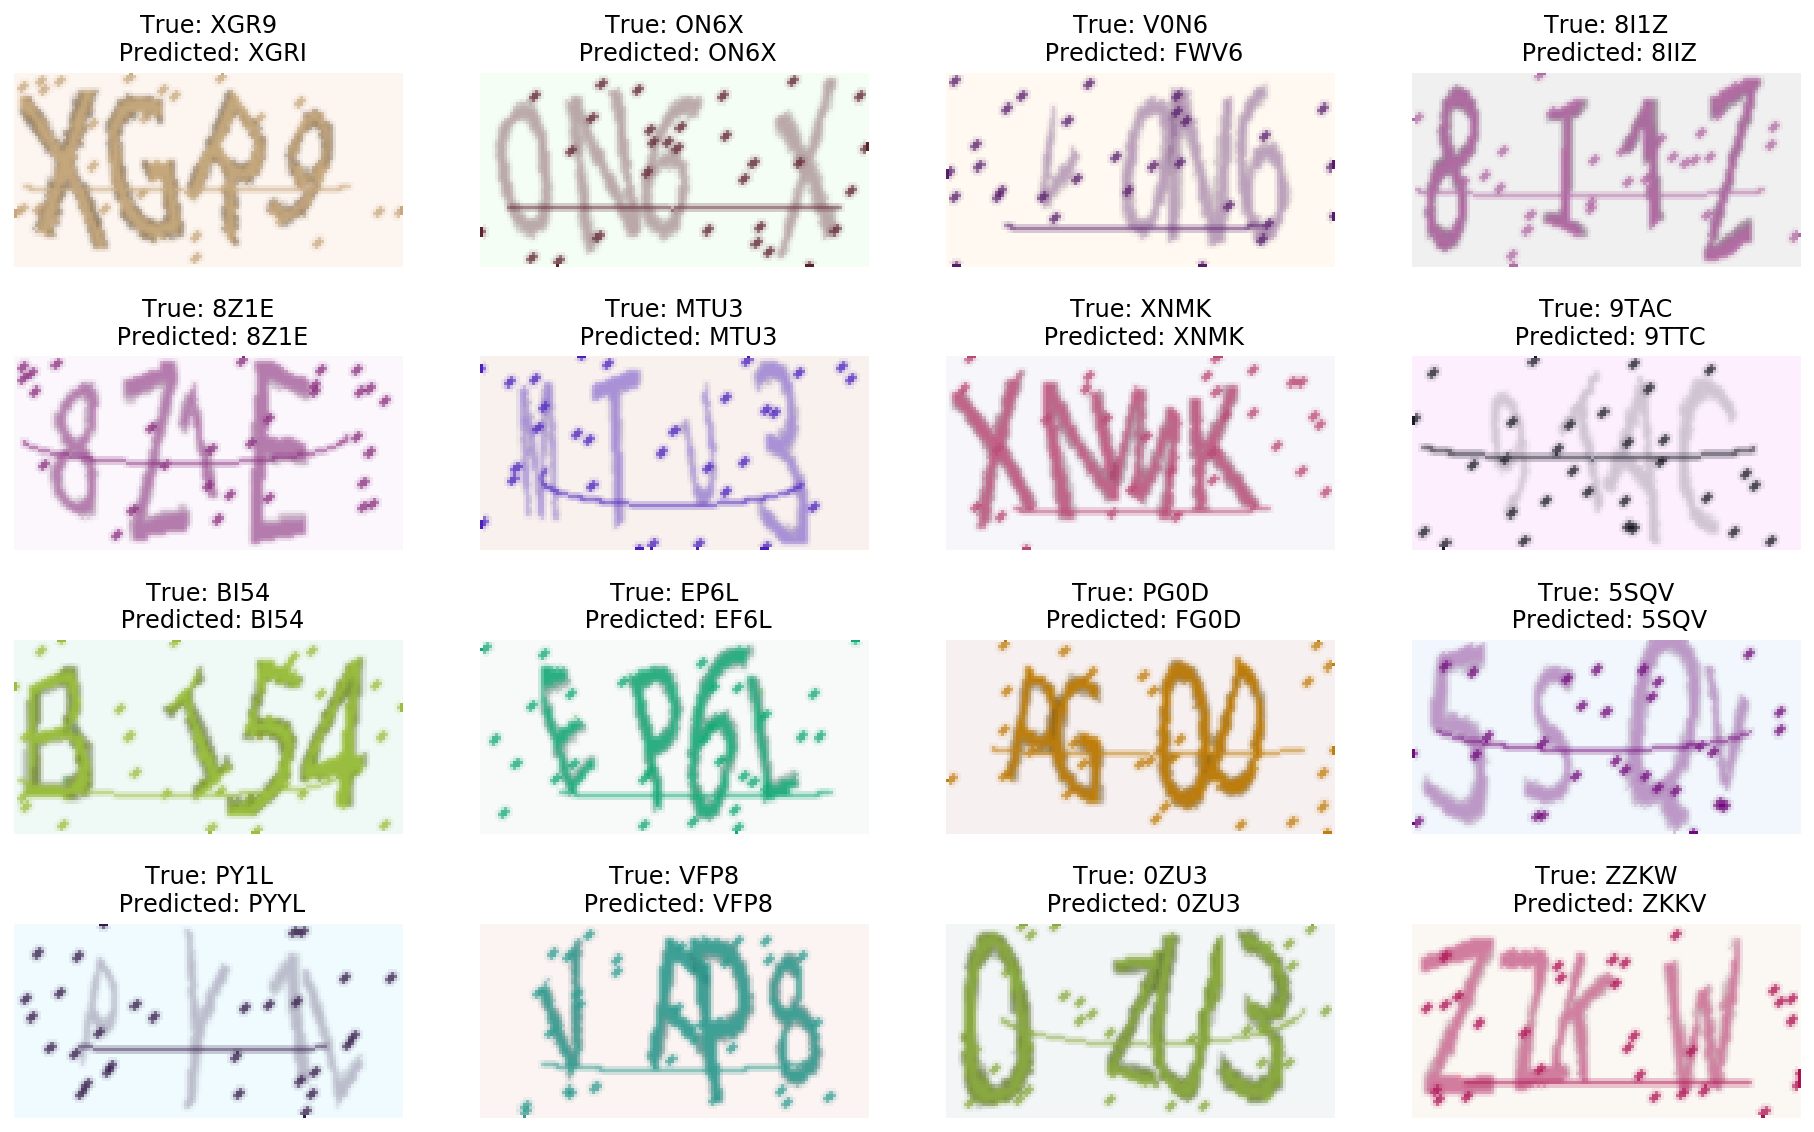

In [82]:
fig = plt.figure(figsize = (16, 10))

for i in range(16):
  ax = fig.add_subplot(4, 4, 1 + i, xticks = [], yticks = [])
  X, y = data[0]
  y_pred = model.predict(X)
  plt.title("True: {}\n Predicted: {}".format(decode(y), decode(y_pred)))
  plt.imshow(X[0], cmap = "gray")
  plt.axis ("off")
plt.show()

### 1. About true label: y

The label y is composed of 4 elements, each element is a one-hot encoder of 36-class. 

Since the image-len is 4, the label y is a 4 by 36 matrix

In [62]:
y

[array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)]

### 2. About the predicted value: y_pred

Similar to y label, instead of the one-hot encoder, for each level, the y_pred is composed of 36 values indicating the probabilities of being each of the 36 classes. 

It is also a 4 by 36 matrix

In [66]:
y_pred

[array([[8.54970672e-09, 6.81616352e-12, 3.59700785e-08, 3.90466652e-04,
         8.04158906e-10, 7.36415386e-05, 4.14446248e-07, 3.60631077e-07,
         6.73072009e-07, 3.74849947e-06, 2.45897009e-12, 6.79890633e-01,
         2.03329531e-09, 5.16209809e-07, 3.10327500e-01, 8.97209439e-03,
         8.68025474e-09, 1.70106505e-04, 1.89477987e-06, 1.42548909e-13,
         2.61694977e-09, 2.71156053e-09, 4.01045828e-11, 3.41017259e-09,
         1.61416551e-07, 7.50318168e-06, 4.76870499e-09, 1.00186975e-04,
         4.82776159e-05, 1.73378067e-09, 1.84923549e-10, 7.43854478e-10,
         6.49115553e-11, 1.91038474e-09, 2.23418173e-09, 1.17146019e-05]],
       dtype=float32),
 array([[9.1832767e-08, 1.6504700e-08, 1.4458977e-04, 8.0922655e-06,
         7.1255177e-05, 2.3267440e-04, 4.0770988e-06, 2.7754547e-06,
         1.0544328e-06, 2.6298785e-08, 1.6716518e-05, 4.7387755e-05,
         1.0830936e-04, 1.0182545e-06, 9.1480994e-01, 1.6341278e-02,
         3.5519265e-06, 3.1842425e-04, 6.2

## Useful reference:
URL_1 = "https://github.com/ypwhs/captcha_break"